<a href="https://colab.research.google.com/github/dongmeisun/dongmeisun/blob/main/AWOL_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Patient delirium risk stratification.
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

> Add blockquote




In [ ]:
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras

import os
import tempfile


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving awos.csv to awos.csv


In [ ]:
import pandas as pd
import io
raw_df = pd.read_csv(io.BytesIO(uploaded[ 'awos.csv' ]))
raw_df.head()
#df = pd.DataFrame(data)

,PatientMrn,age,asa,proc_risk,world,orient,admission,him
0,543498,70,3,2,0,0,2,0
1,2925689,57,2,2,0,0,2,0
2,2925689,57,2,2,0,0,2,0
3,2265743,86,3,2,0,0,2,1
4,1182578,70,2,2,0,0,2,0


In [ ]:
neg, pos = np.bincount(raw_df['him'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 33621
    Positive: 303 (0.90% of total)



In [ ]:

num_cols=['age']
cat_cols=['asa','proc_risk','world','orient','admission','him']

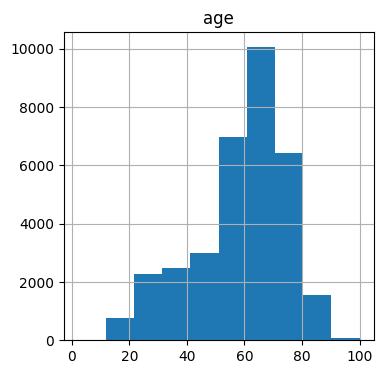

In [ ]:
# Creating histograms
raw_df[num_cols].hist(figsize = (4, 4))

plt.show()

In [ ]:
for i in cat_cols:
    print(df[i].value_counts(normalize = True))

    print('*' * 40)

NameError: name 'df' is not defined

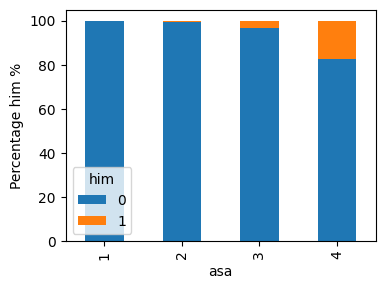

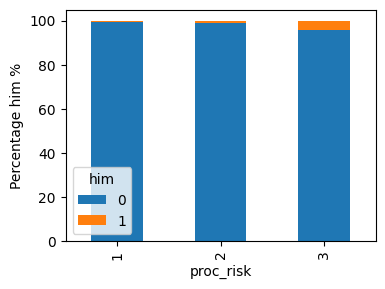

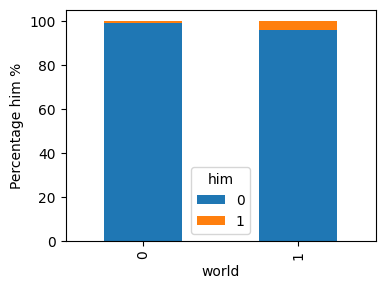

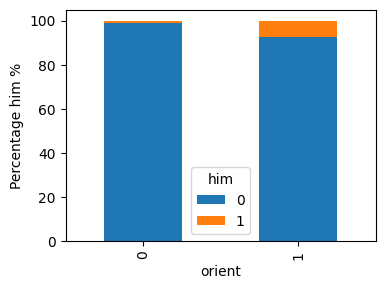

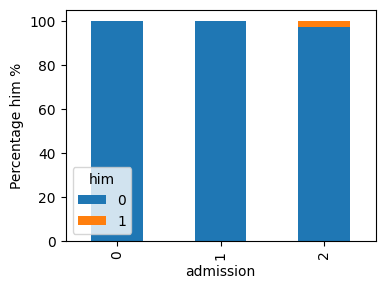

In [ ]:
for i in cat_cols:
    if i != 'him':
        (pd.crosstab(raw_df[i], raw_df['him'], normalize = 'index')*100).plot(kind = 'bar', figsize = (4, 3), stacked = True)
        plt.ylabel('Percentage him %')

In [ ]:
# Separating the target variable and other variables
Y = df.him
X = df.drop(columns=['him', 'PatientMrn'])

NameError: name 'df' is not defined

In [ ]:
# Scaling the data
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [ ]:
# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)


In [ ]:
def metrics_score(actual, predicted):

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not Attrite', 'Attrite'], yticklabels = ['Not Attrite', 'Attrite'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

In [ ]:
# define class weights
w = {0:1, 1:99}
# Fitting the logistic regression model
lg = LogisticRegression(random_state=13, class_weight=w)

lg.fit(x_train,y_train)

LogisticRegression(class_weight={0: 1, 1: 99}, random_state=13)

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     19990
           1       0.04      0.85      0.08       182

    accuracy                           0.81     20172
   macro avg       0.52      0.83      0.49     20172
weighted avg       0.99      0.81      0.89     20172



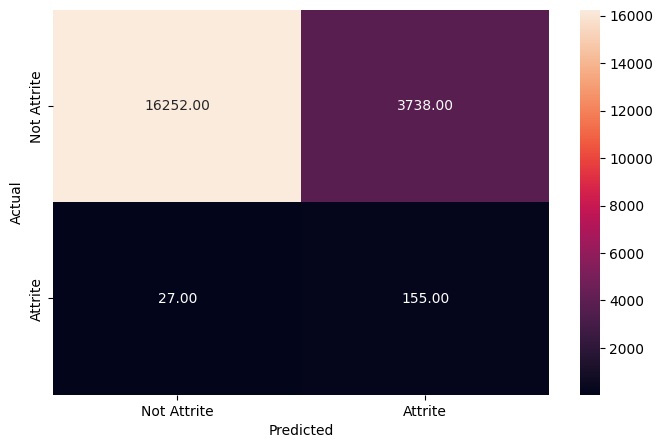

In [ ]:
# Checking the performance on the training data
y_pred_train = lg.predict(x_train)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     13328
           1       0.04      0.85      0.08       121

    accuracy                           0.81     13449
   macro avg       0.52      0.83      0.49     13449
weighted avg       0.99      0.81      0.89     13449



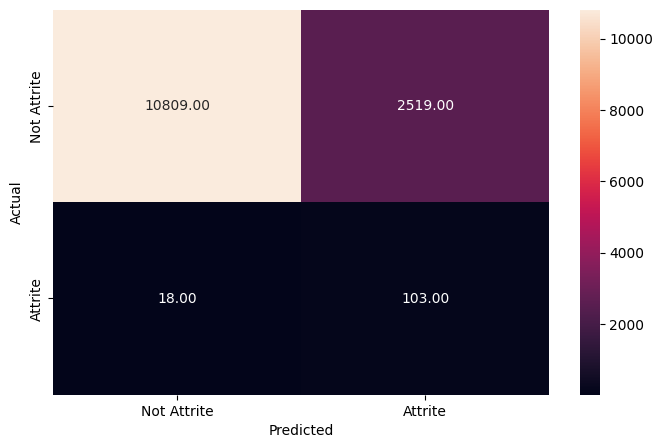

In [ ]:
# Checking the performance on the test dataset
y_pred_test = lg.predict(x_test)
metrics_score(y_test, y_pred_test)

In [ ]:
# Printing the coefficients of logistic regression
cols = X.columns

coef_lg = lg.coef_

pd.DataFrame(coef_lg,columns = cols).T.sort_values(by = 0, ascending = False)

,0
age,1.452624
admission,0.985348
asa,0.504819
proc_risk,0.179563
world,0.170905
orient,0.044506


In [ ]:
odds = np.exp(lg.coef_[0]) # Finding the odds

# Adding the odds to a DataFrame and sorting the values
pd.DataFrame(odds, x_train.columns, columns = ['odds']).sort_values(by = 'odds', ascending = False)


,odds
age,4.274315
admission,2.678744
asa,1.656685
proc_risk,1.196695
world,1.186378
orient,1.045512


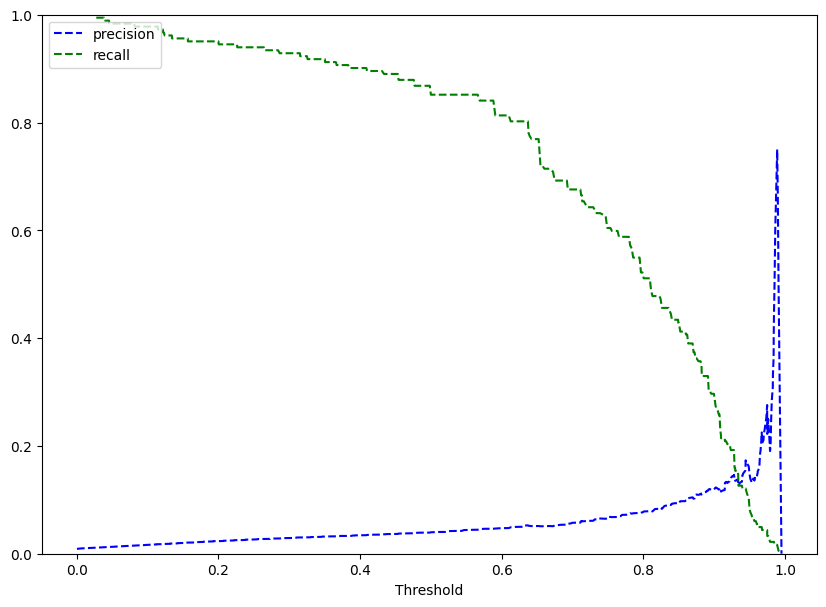

In [ ]:
y_scores_lg = lg.predict_proba(x_train) # predict_proba gives the probability of each observation belonging to each class


precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:, 1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize = (10, 7))

plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label = 'precision')

plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')

plt.xlabel('Threshold')

plt.legend(loc = 'upper left')

plt.ylim([0, 1])

plt.show()

In [ ]:
# Use a utility from sklearn to split and shuffle your dataset.
cleaned_df = raw_df.copy()
cleaned_df.pop('PatientMrn')
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('him')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('him')).reshape(-1, 1)
test_labels = np.array(test_df.pop('him')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [ ]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')


Average class probability in training set:   0.0087
Average class probability in validation set: 0.0097
Average class probability in test set:       0.0094


In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (21516, 1)
Validation labels shape: (5380, 1)
Test labels shape: (6725, 1)
Training features shape: (21516, 6)
Validation features shape: (5380, 6)
Test features shape: (6725, 6)


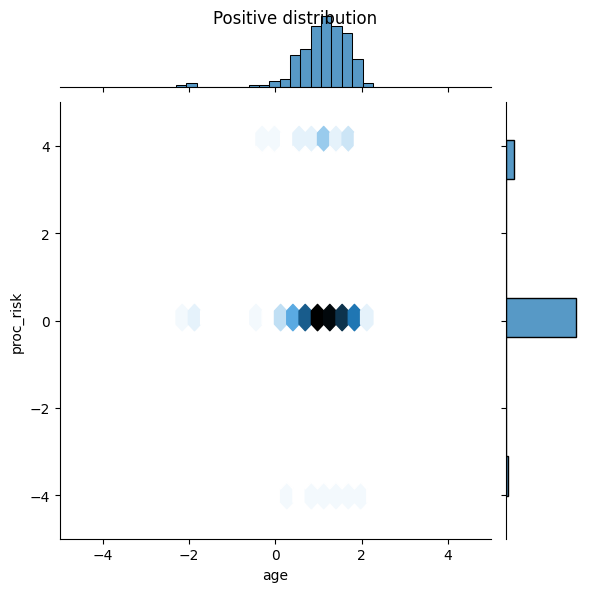

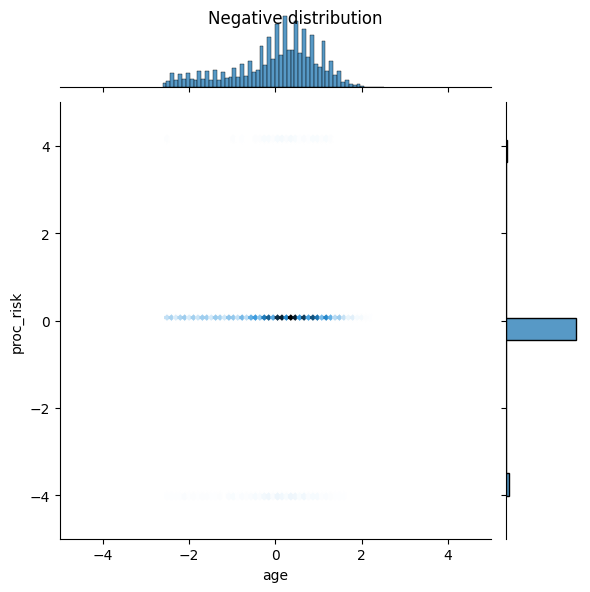

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['age'], y=pos_df['proc_risk'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['age'], y=neg_df['proc_risk'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

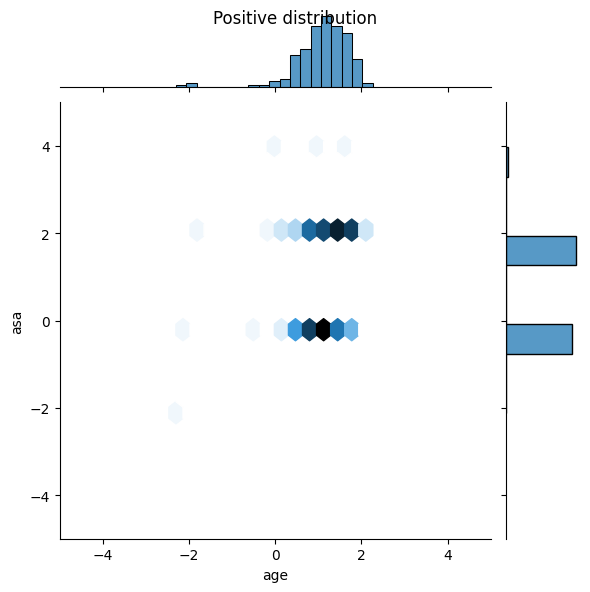

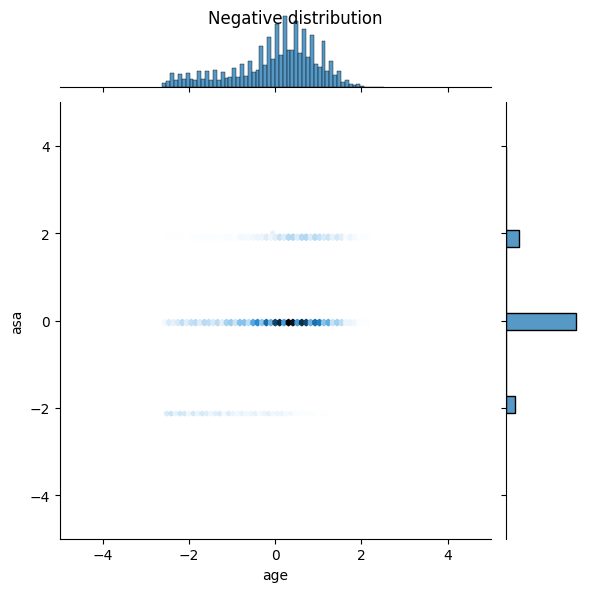

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['age'], y=pos_df['asa'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['age'], y=neg_df['asa'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 300

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [ ]:
model = make_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 16)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[0.15321986],
       [0.10318824],
       [0.10232141],
       [0.20469514],
       [0.16803749],
       [0.1085266 ],
       [0.14577812],
       [0.19514404],
       [0.1436758 ],
       [0.10672073]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0533


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.70012026])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.00941752],
       [0.00682188],
       [0.00679676],
       [0.01227708],
       [0.00468437],
       [0.00697455],
       [0.01419606],
       [0.02118148],
       [0.01536227],
       [0.00692328]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.0493


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

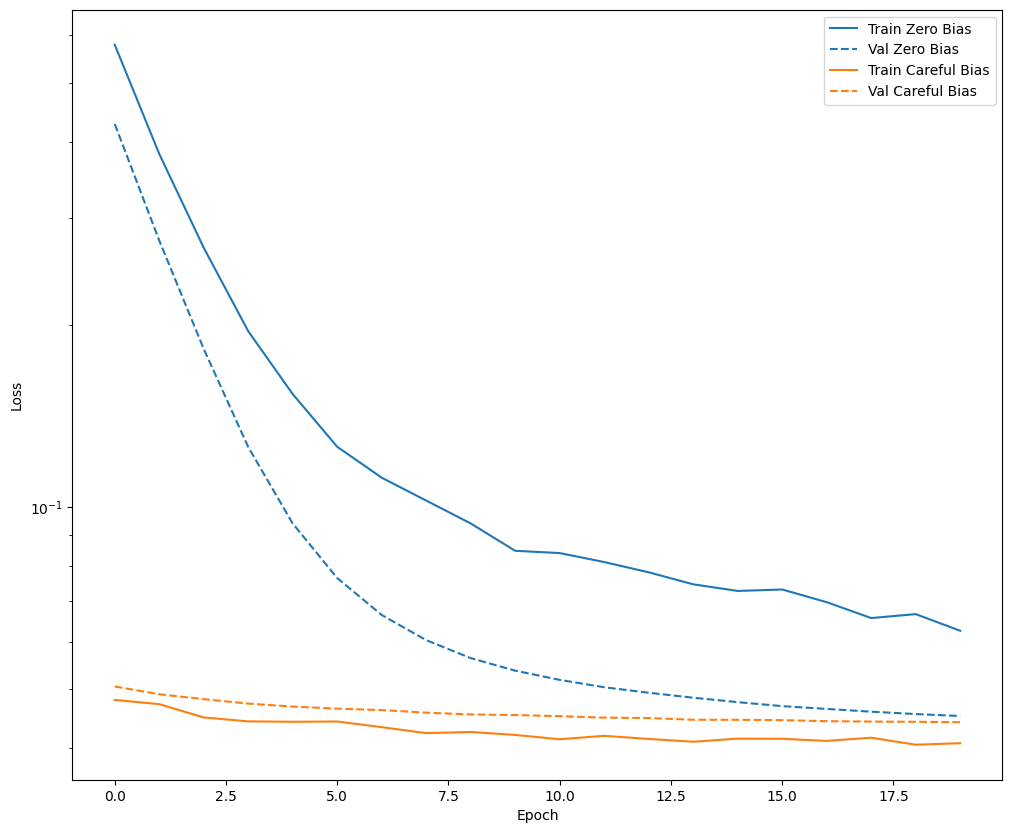

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - Brier score: 0.0089 - accuracy: 0.9909 - auc: 0.7712 - cross entropy: 0.0475 - fn: 148.5342 - fp: 0.0000e+00 - loss: 0.0497 - prc: 0.0424 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 16325.0547 - tp: 0.0000e+00 - val_Brier score: 0.0095 - val_accuracy: 0.9903 - val_auc: 0.7760 - val_cross entropy: 0.0509 - val_fn: 52.0000 - val_fp: 0.0000e+00 - val_loss: 0.0509 - val_prc: 0.0493 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 5328.0000 - val_tp: 0.0000e+00
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Brier score: 0.0087 - accuracy: 0.9911 - auc: 0.7496 - cross entropy: 0.0481 - fn: 99.8904 - fp: 0.8767 - loss: 0.0481 - prc: 0.0414 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 10992.8223 - tp: 0.0000e+00 - val_Brier score: 0.0094 - val_accuracy: 0.9903 - val_auc: 0.8110 - val_cross entropy: 0.0493 - val_fn: 52.0000 - val_fp: 0.0000e+00 - val_loss: 0.0493 - val_prc: 0.0488 - val_precision: 0.0000e+00 

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


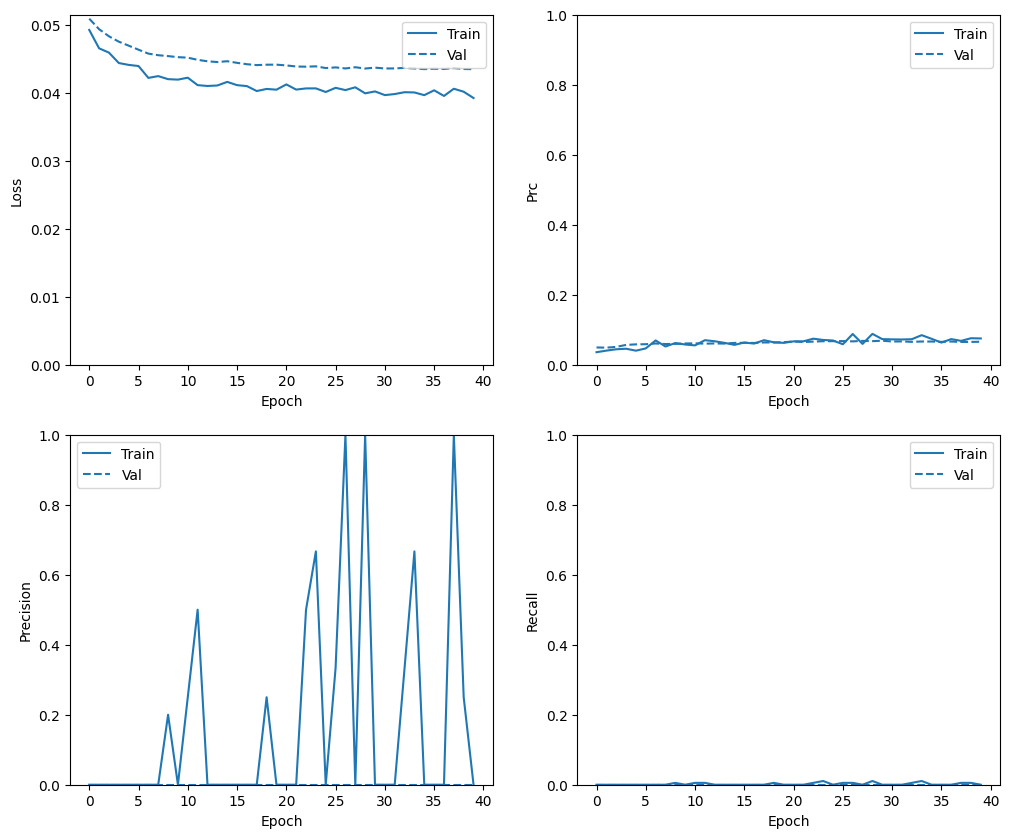

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.04081586375832558
compile_metrics :  0.04081586375832558

Legitimate Transactions Detected (True Negatives):  6662
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  63
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  63


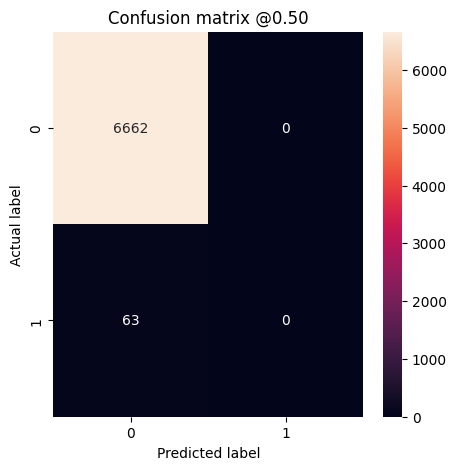

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


Legitimate Transactions Detected (True Negatives):  6661
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  62
Fraudulent Transactions Detected (True Positives):  1
Total Fraudulent Transactions:  63
Legitimate Transactions Detected (True Negatives):  5253
Legitimate Transactions Incorrectly Detected (False Positives):  1409
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  57
Total Fraudulent Transactions:  63


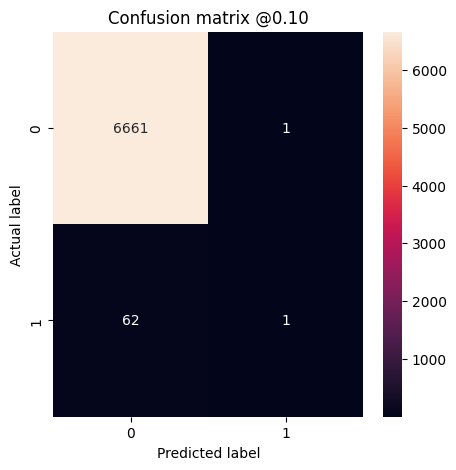

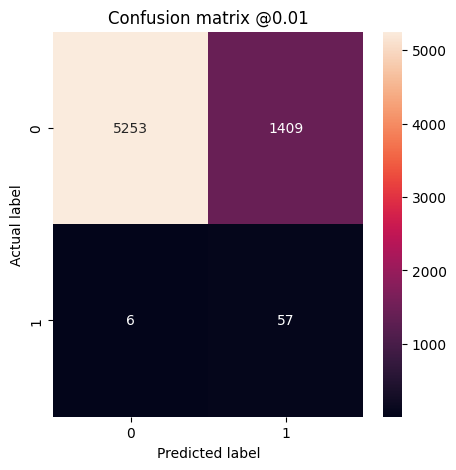

In [ ]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

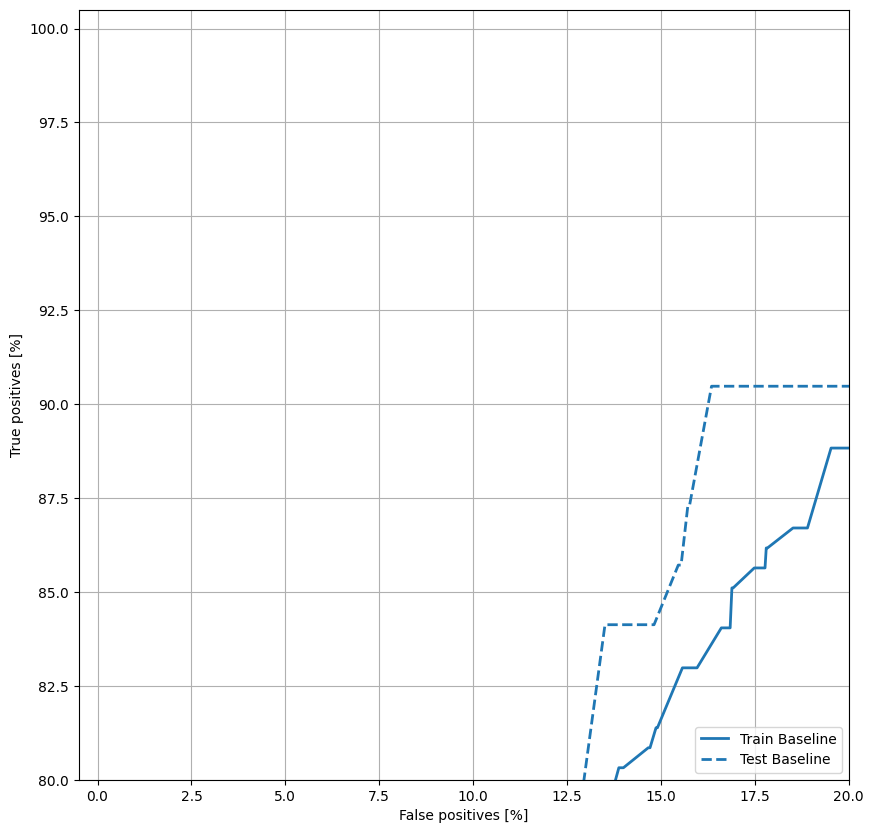

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


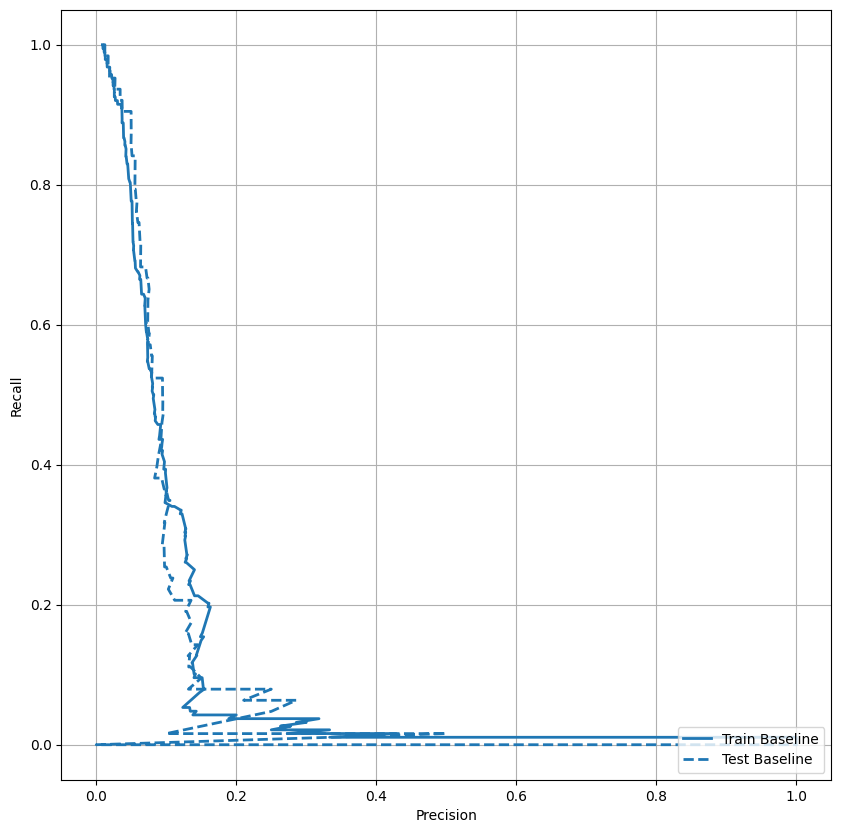

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 55.48


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - Brier score: 0.0087 - accuracy: 0.9910 - auc: 0.7952 - cross entropy: 0.0457 - fn: 160.0274 - fp: 0.0000e+00 - loss: 2.0774 - prc: 0.0531 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 17658.5625 - tp: 0.0000e+00 - val_Brier score: 0.0094 - val_accuracy: 0.9903 - val_auc: 0.7851 - val_cross entropy: 0.0512 - val_fn: 52.0000 - val_fp: 0.0000e+00 - val_loss: 0.0512 - val_prc: 0.0502 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 5328.0000 - val_tp: 0.0000e+00
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Brier score: 0.0086 - accuracy: 0.9916 - auc: 0.7147 - cross entropy: 0.0498 - fn: 96.2192 - fp: 0.7671 - loss: 1.7686 - prc: 0.0368 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 10996.6025 - tp: 0.0000e+00 - val_Brier score: 0.0095 - val_accuracy: 0.9903 - val_auc: 0.8060 - val_cross entropy: 0.0525 - val_fn: 52.0000 - val_fp: 0.0000e+00 - val_loss: 0.0525 - val_prc: 0.0491 - val_precision: 0.0000e+00 

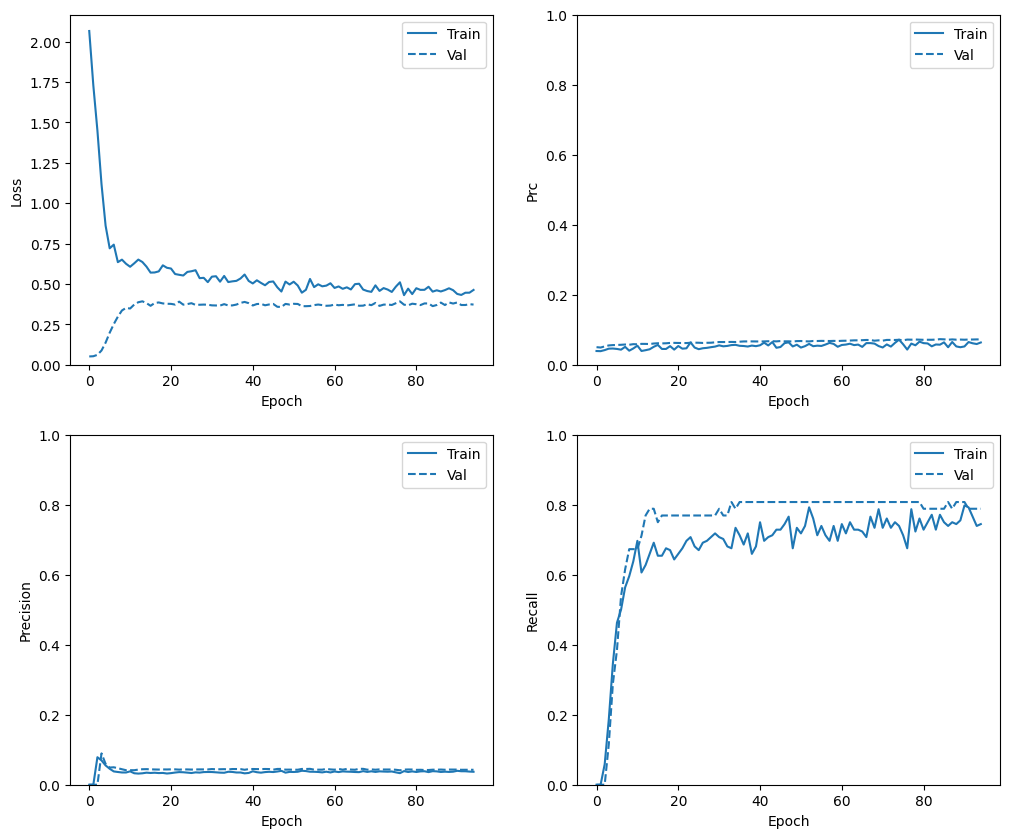

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


loss :  0.39237263798713684
compile_metrics :  0.39237263798713684

Legitimate Transactions Detected (True Negatives):  5421
Legitimate Transactions Incorrectly Detected (False Positives):  1241
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  57
Total Fraudulent Transactions:  63


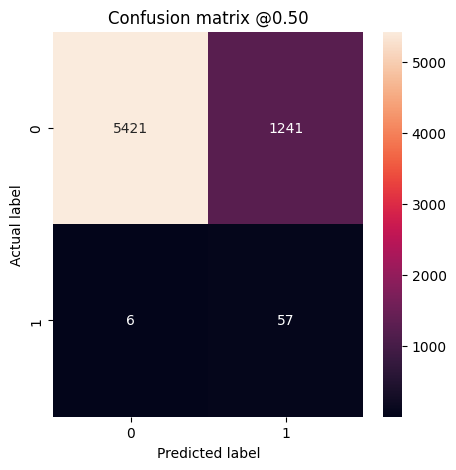

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

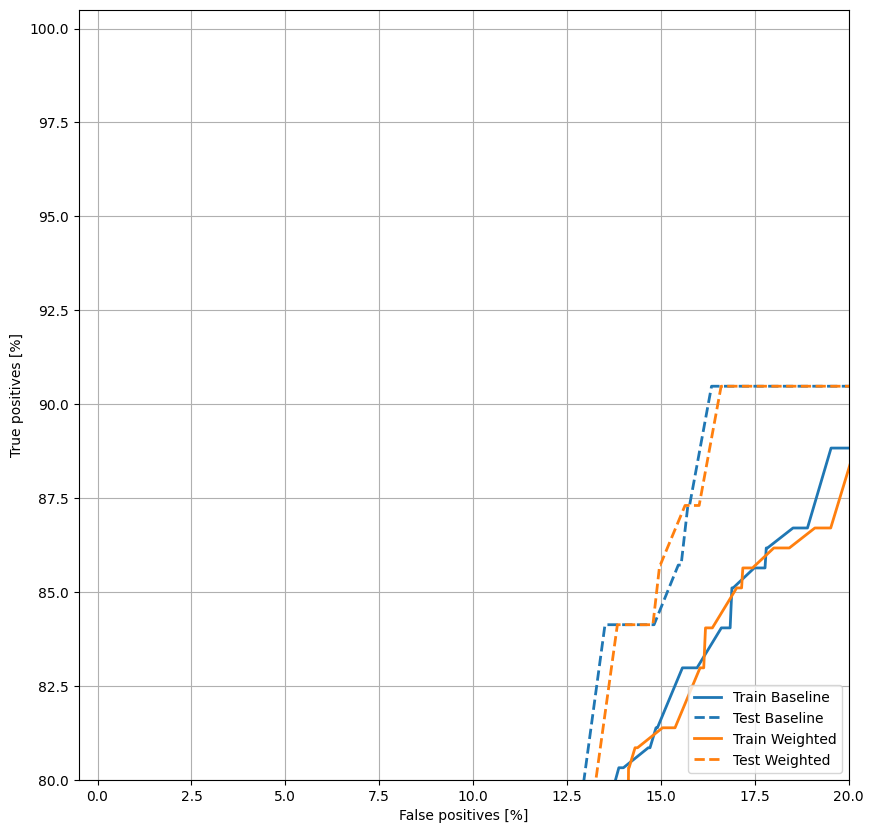

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

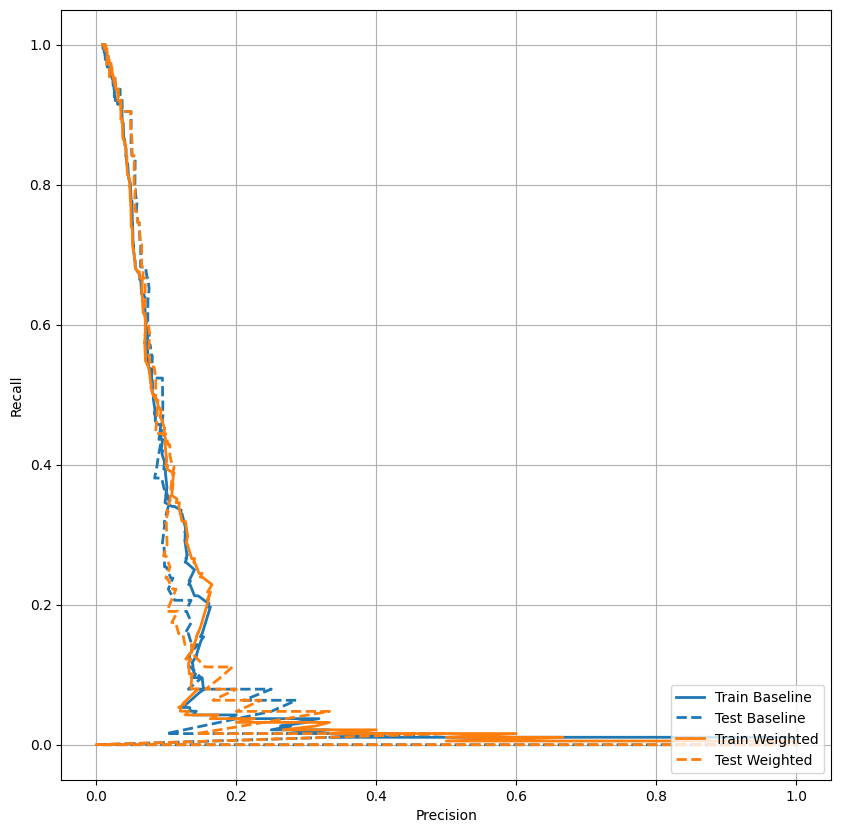

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(21328, 6)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape


(42656, 6)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 1.70090329  1.94517847  0.0674658  -0.15612914 -0.06109042  1.29509998]

Label:  [1]


In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5366666666666666


In [ ]:
resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch

223

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - Brier score: 0.1915 - accuracy: 0.7160 - auc: 0.7833 - cross entropy: 0.5731 - fn: 3957.2366 - fp: 7425.6875 - loss: 0.6406 - prc: 0.6485 - precision: 0.5888 - recall: 0.7504 - tn: 16152.1699 - tp: 12938.5674 - val_Brier score: 0.1752 - val_accuracy: 0.7392 - val_auc: 0.8773 - val_cross entropy: 0.5257 - val_fn: 5.0000 - val_fp: 1398.0000 - val_loss: 0.5257 - val_prc: 0.0589 - val_precision: 0.0325 - val_recall: 0.9038 - val_tn: 3930.0000 - val_tp: 47.0000
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - Brier score: 0.1529 - accuracy: 0.7958 - auc: 0.8635 - cross entropy: 0.4761 - fn: 2464.2097 - fp: 4279.0225 - loss: 0.4761 - prc: 0.8437 - precision: 0.7671 - recall: 0.8495 - tn: 12628.0713 - tp: 14377.3574 - val_Brier score: 0.1435 - val_accuracy: 0.7758 - val_auc: 0.8874 - val_cross entropy: 0.4358 - val_fn: 5.0000 - val_fp: 1201.0000 - val_loss: 0.4358 - val_prc: 0.0652 - val_precision: 0.0377 - val_recall: 0.9038 - va

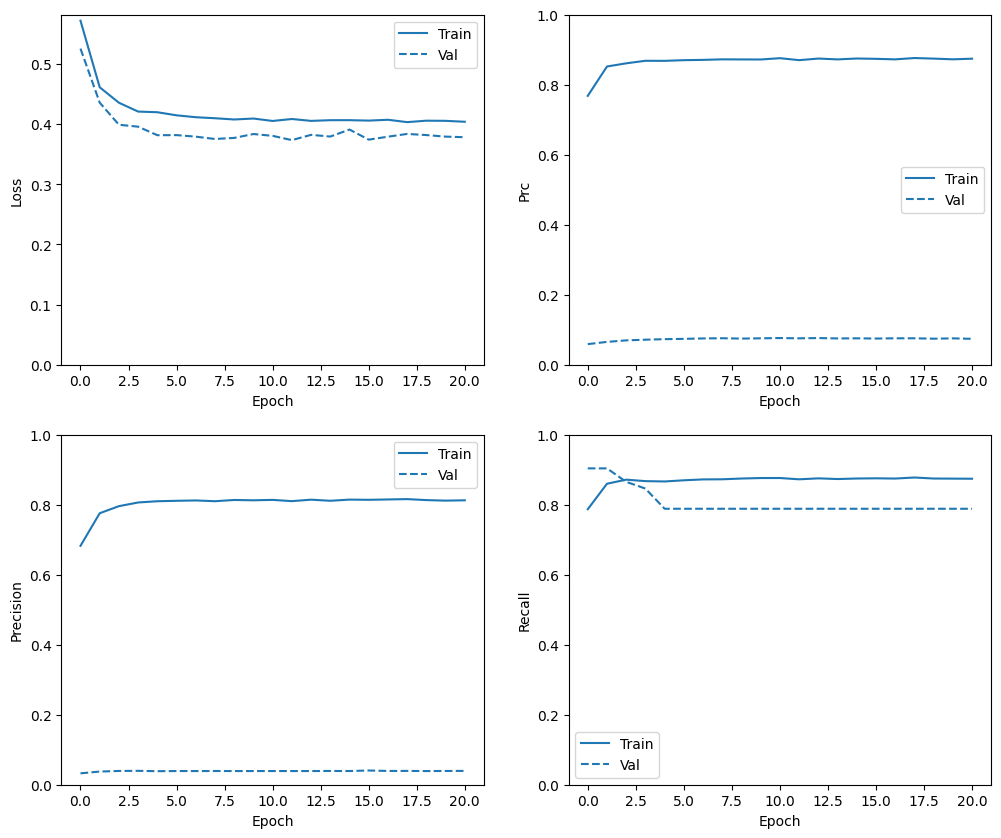

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_ds))

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - Brier score: 0.1667 - accuracy: 0.7400 - auc: 0.7870 - cross entropy: 0.4998 - fn: 487.2857 - fp: 1811.0000 - loss: 0.7315 - prc: 0.3522 - precision: 0.3598 - recall: 0.7045 - tn: 5192.3335 - tp: 1175.0952 - val_Brier score: 0.2436 - val_accuracy: 0.5985 - val_auc: 0.7737 - val_cross entropy: 0.6796 - val_fn: 10.0000 - val_fp: 2150.0000 - val_loss: 0.6796 - val_prc: 0.0533 - val_precision: 0.0192 - val_recall: 0.8077 - val_tn: 3178.0000 - val_tp: 42.0000
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - Brier score: 0.2323 - accuracy: 0.6400 - auc: 0.7003 - cross entropy: 0.6814 - fn: 422.4762 - fp: 752.0952 - loss: 0.6814 - prc: 0.7190 - precision: 0.6182 - recall: 0.7458 - tn: 885.2381 - tp: 1225.9048 - val_Brier score: 0.2374 - val_accuracy: 0.6450 - val_auc: 0.7921 - val_cross entropy: 0.6680 - val_fn: 9.0000 - val_fp: 1901.0000 - val_loss: 0.6680 - val_prc: 0.0516 - val_precision: 0.0221 - val_recall: 0.8269 - val_tn: 342

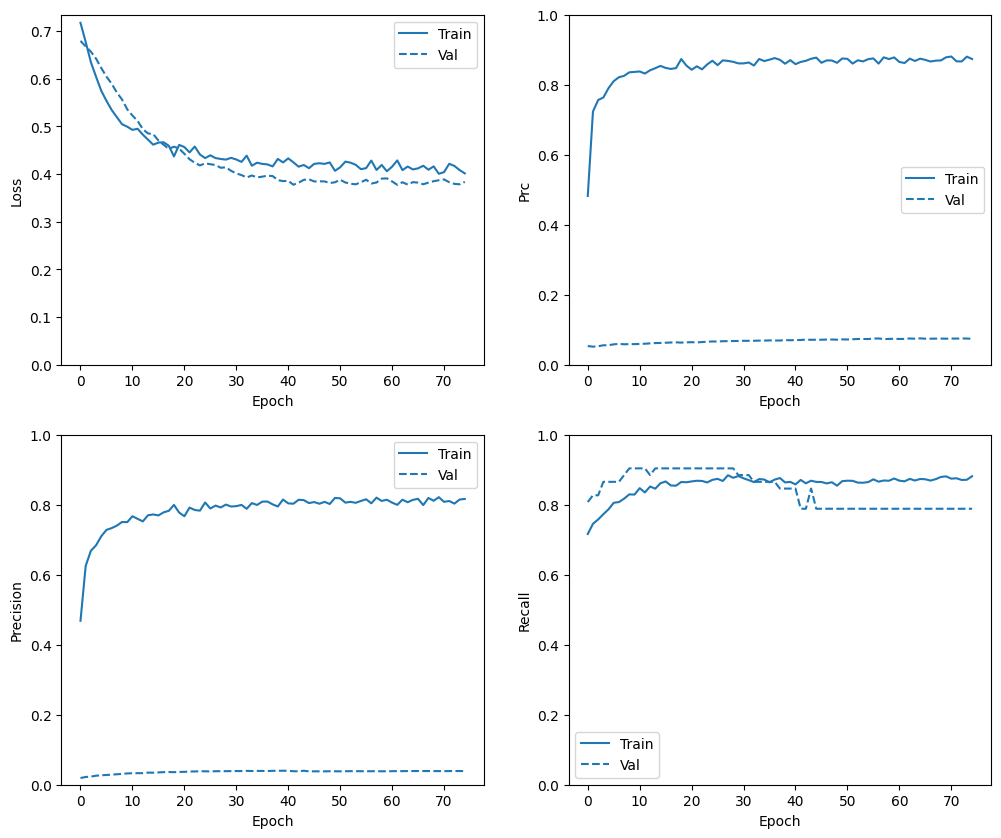

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


loss :  0.41373035311698914
compile_metrics :  0.41373035311698914

Legitimate Transactions Detected (True Negatives):  5289
Legitimate Transactions Incorrectly Detected (False Positives):  1373
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  57
Total Fraudulent Transactions:  63


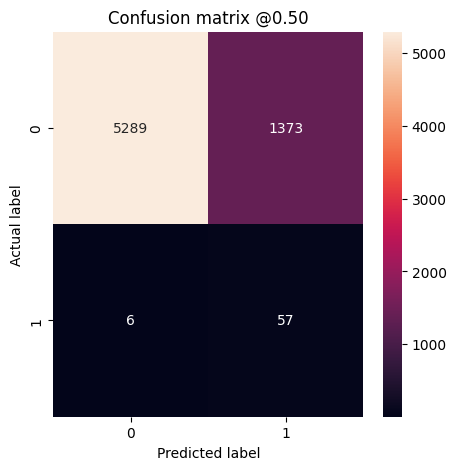

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

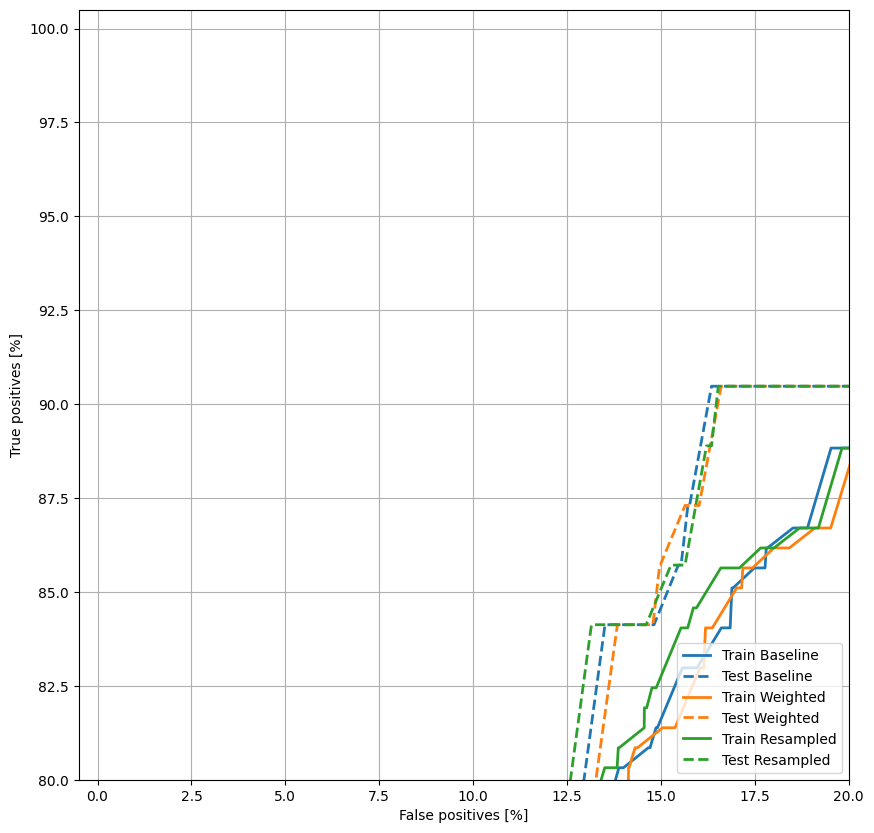

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

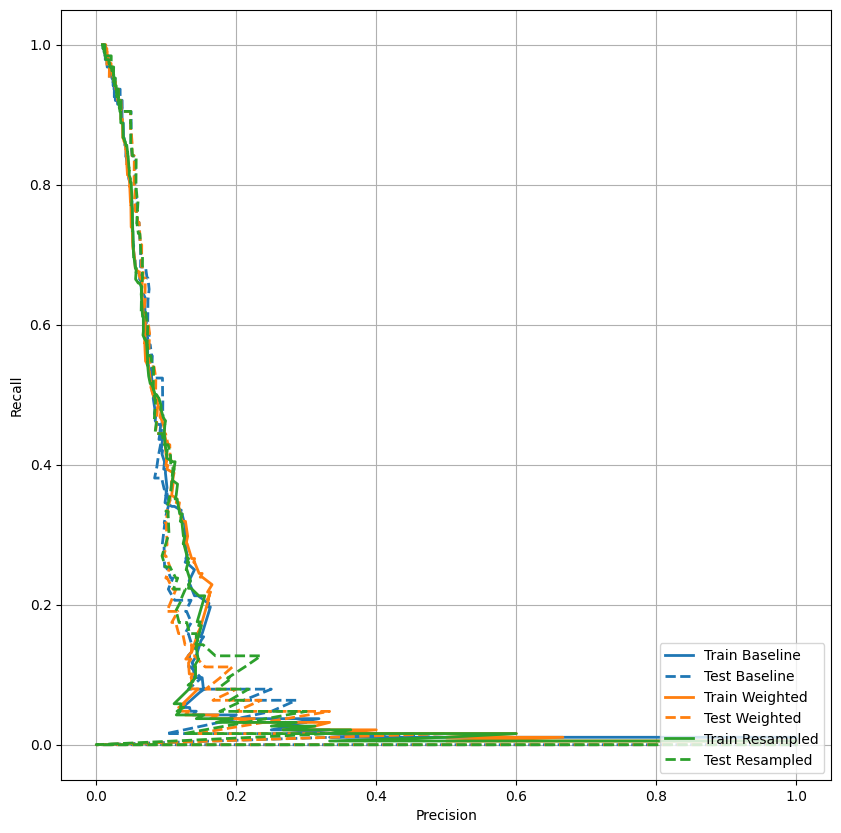

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
!jupyter nbconvert --to html 'AWOL.ipynb'


[NbConvertApp] WARNING | pattern 'AWOL.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut